# Il problema

Un azienda automobilistica ha intenzione di espandersi in un nuovo mercato utilizzando la sua gamma di prodotti già esistenti (P1, P2, P3, P4, e P5). Dopo alcune ricerche hanno scoperto che il comportamento sul nuovo mercato di obiettivo è simile a quello in cui operano attualmente.

Nell'attuale mercato il team di vendite ha classificato i possibili acquirenti in 4 diverse categorie (A, B, C, D). Con questa segmentazione possono proporre servizi e pubblicità mirate per i diversi tipi di clienti. Questa stategia ha funzionato particolarmente bene finora e quindi l'azienda punta ad utilizzarla anche sul nuovo mercato dove ha identificato 2627 possibili nuovi clienti.

L'obiettivo è quello di prevedere correttamente il gruppo di appartenzenza dei nuovi clienti.

## I dati

| Variable | Definition |
| :-: | :-: |
| ID | Identificativo univoco|
| Gender | Sesso del cliente|
| Ever_Married | Stato civile del cliente |
| Age | Età del cliente |
| Graduated | Il cliente è laureato? |
| Profession | Lavoro del cliente |
| Work_Experiecen | Esperienza lavorativa in anni |
| Spending_Score | Punteggio di spesa del cliente |
| Family Size | Numero di componenti del nucleo familiare del cliente (cliente incluso)|
| Var_1 | Categoria anonima per il cliente |
| Segmentation | (target) Segmento di appartenenza del cliente|


In [1]:
#Data wrangling
import numpy as np
import pandas as pd
from collections import Counter

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno
from matplotlib.ticker import EngFormatter
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

#Machine Learning 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

#Model evaluation 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

plt.rcParams["figure.figsize"] = 10,6
plt.style.use('ggplot')

## Import 

In [2]:
train_data = pd.read_csv('Customer_Train.csv')
test_data = pd.read_csv('Customer_Test.csv')
data = pd.concat([train_data, test_data])
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [3]:
print('Train set shape:',train_data.shape)
print('Test set shape:',test_data.shape)

Train set shape: (8068, 11)
Test set shape: (2627, 11)


In realtà i due set non sono divisi in modo corretto perché la variabile target è contenuta anche nel test set, per questo uniamo i due dataframe e li consideriamo insieme. Successivamente, prima di applicare il modello di machine learning divideremo i dati in train e test.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10695 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  float64
 9   Var_1            10587 non-null  object 
 10  Segmentation     10695 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 1002.7+ KB


Si noti che le colonne che contengono varaibili qualitative ordinali o binarie, sono resgristate come "object". Dovremo codificarle correttamente prima di applicare un algoritmo di Machine Learning. È anche possibile vedere che ci sono dei dati mancanti, studiamoli più nel dettaglio.

In [5]:
data.isnull().sum()

ID                    0
Gender                0
Ever_Married        190
Age                   0
Graduated           102
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation          0
dtype: int64

Abbiamo diverse colonne con valori mancanti che dobbiamo gestire, tuttavia non è detto che sia possibile usare lo stesso modello per tutte. Ad esempio i valori mancanti della colonna _Work_Experience_ potrebbero indicare persone che non sono mai state impiegate, e quindi sarebbe utile sostituire questi valori mancanti con 0; la stessa cosa vale per la colonna _Profession_, i valori mancanti potrebbero indicare persone che sono attualmente disoccupate.

Visualizziamo la distribuzione dei dati mancanti:

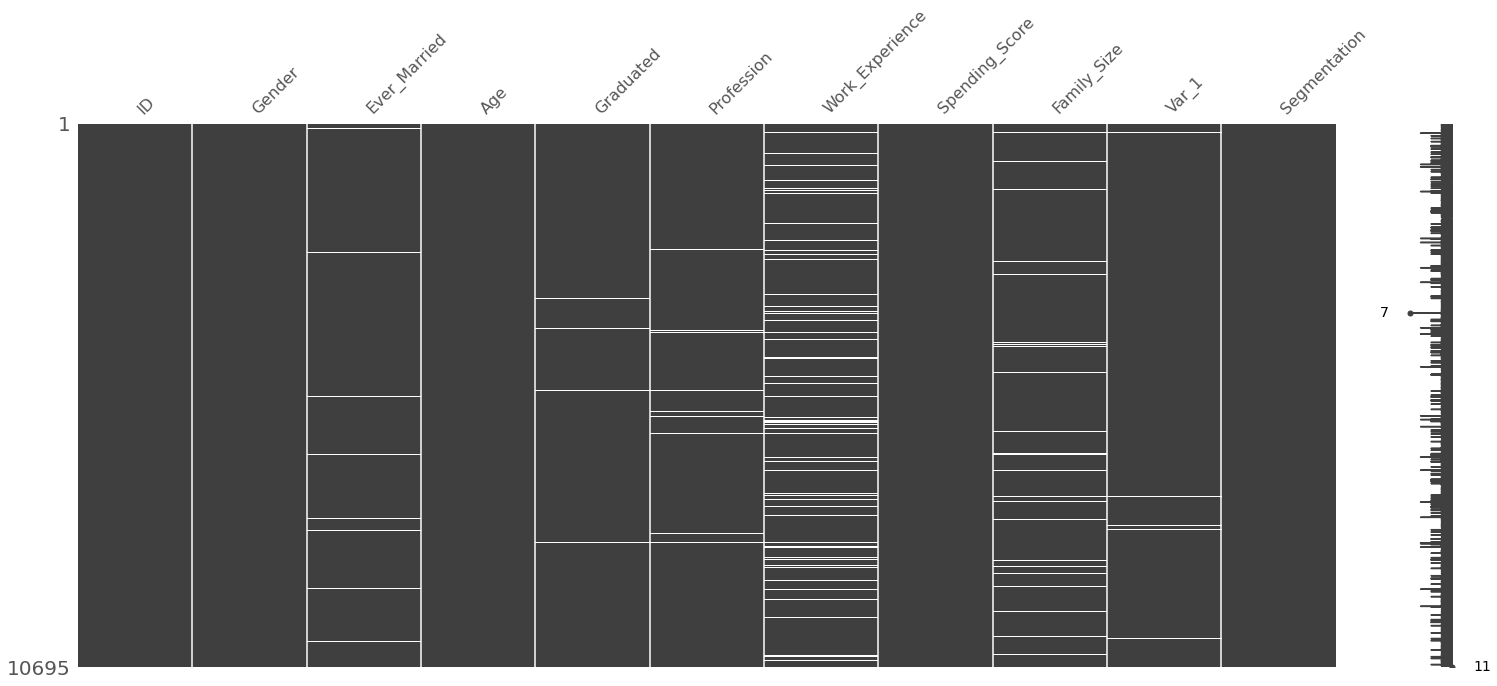

In [6]:
missingno.matrix(data)
plt.show()

Le colonne più problematiche a livello di dati mancanti sono _Work_experience_ e _Familiy_Size_. A volte utilizzando una rappresentazione grafica è più facile avere un'idea di come sono composti i dati con cui stiamo lavorando.

In [7]:
data.duplicated().sum()

38

Sono presenti anche dei valori duplicati.

In [8]:
data.describe()

,ID,Age,Work_Experience,Family_Size
count,10695.000000,10695.000000,9597.000000,10247.000000
mean,463468.088640,43.511828,2.619777,2.844052
std,2600.966411,16.774158,3.390790,1.536427
min,458982.000000,18.000000,0.000000,1.000000
25%,461220.500000,30.000000,0.000000,2.000000
50%,463451.000000,41.000000,1.000000,3.000000
75%,465733.500000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [9]:
#Visualizzo le variabili categoriche

categorical_col = data.select_dtypes('object')
for i in categorical_col:
    print(data[i].value_counts(), end="\n\n")

Male      5841
Female    4854
Name: Gender, dtype: int64

Yes    6163
No     4342
Name: Ever_Married, dtype: int64

Yes    6570
No     4023
Name: Graduated, dtype: int64

Artist           3318
Healthcare       1750
Entertainment    1250
Engineer          935
Doctor            930
Lawyer            844
Executive         775
Marketing         403
Homemaker         328
Name: Profession, dtype: int64

Low        6494
Average    2599
High       1602
Name: Spending_Score, dtype: int64

Cat_6    6910
Cat_4    1475
Cat_3    1089
Cat_2     563
Cat_7     269
Cat_1     167
Cat_5     114
Name: Var_1, dtype: int64

D    3027
A    2818
C    2442
B    2408
Name: Segmentation, dtype: int64



# Pulizia dei dati 

Come prima cosa rimuoviamo i valori duplicati 

In [10]:
data.drop_duplicates(inplace=True)

Adesso dobbiamo decidere come gestire i dati che presentano dei valori mancanti. Possiamo eliminare le righe o le colonne che contengono i valori mancanti, oppure decidere di sostituire i dati mancanti con altri valori significativi in base alla variabile che stiamo considerando.

Per quanto riguarda le variabili numeriche Work_Experience e Family_Size, sostituiamo i valori mancanti con la mediana, in modo da non subire l'effetto di outliers.

Per quanto riguarda le variabili categoriche, consideriamo i valori mancanti di Ever_Married come 'No', i valori mancanti di Graduated come 'No' e eliminiamo i valori mancanti di Profession e Var_1 perché non abbiamo un modo efficiente per sostituirli.

Calcoliamo la mediana di Work_Experience e Family_Size

In [11]:
W_median = data['Work_Experience'].median()
F_median = data['Family_Size'].median()

print('Work_Experience median:', W_median)
print('Family_Size median:', F_median)

Work_Experience median: 1.0
Family_Size median: 2.0


In [12]:
#Sostituisco i valori mancanti per tutte le variabili
data['Work_Experience'] = data['Work_Experience'].fillna(W_median)
data['Family_Size'] = data['Family_Size'].fillna(F_median)
data['Ever_Married'].fillna('No',inplace=True)
data['Graduated'].fillna('No',inplace=True)
data.dropna(subset=['Profession'],inplace=True)
data.dropna(subset=['Var_1'],inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10390 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10390 non-null  int64  
 1   Gender           10390 non-null  object 
 2   Ever_Married     10390 non-null  object 
 3   Age              10390 non-null  int64  
 4   Graduated        10390 non-null  object 
 5   Profession       10390 non-null  object 
 6   Work_Experience  10390 non-null  float64
 7   Spending_Score   10390 non-null  object 
 8   Family_Size      10390 non-null  float64
 9   Var_1            10390 non-null  object 
 10  Segmentation     10390 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 974.1+ KB


Infine rimuoviamo la colonna ID perché non verrà usata nell'analisi

In [13]:
data = data.drop('ID', axis=1)

## Exploratory Data Analysis

### variabili categoriche

Ricordiamo che la nostra variabile target è _Segmentation_ quindi visualizziamo come si comporta questa variabile rispetto alle features categoriche.

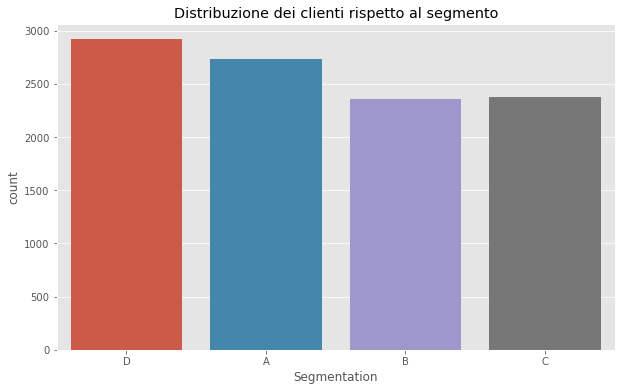

In [14]:
sns.countplot(x=data.Segmentation)
plt.title('Distribuzione dei clienti rispetto al segmento');

Il segmento D è il più rappresentativo.

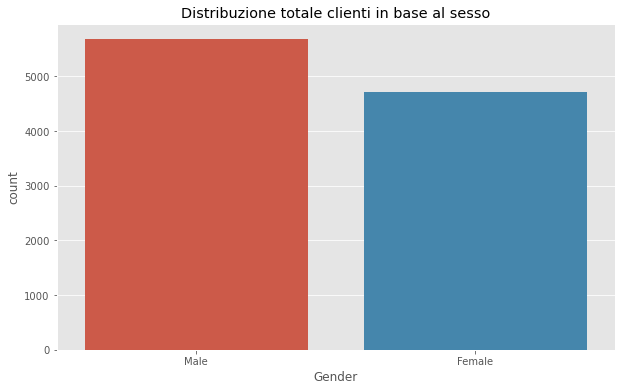

In [15]:
sns.countplot(x=data.Gender)
plt.title('Distribuzione totale clienti in base al sesso');

La maggioranza della clientela è composta da individui di sesso maschile.

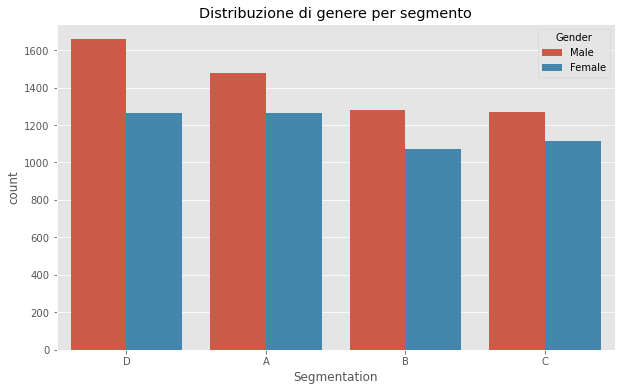

In [16]:
sns.countplot(data=data, x='Segmentation', hue='Gender')
plt.title('Distribuzione di genere per segmento');

In ogni segmento gli uomini sono la maggioranza. La differenza minore si registra nel segmento C.

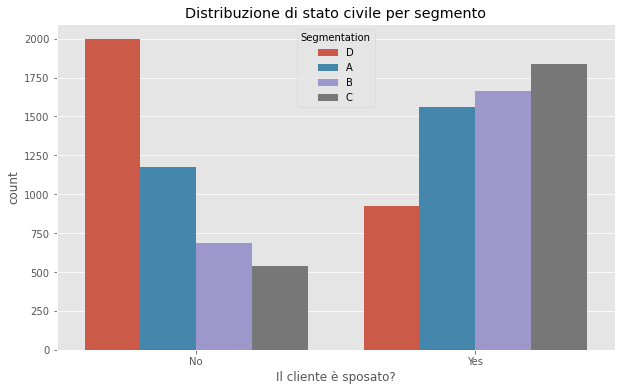

In [17]:
sns.countplot(data=data, x='Ever_Married', hue='Segmentation')
plt.title('Distribuzione di stato civile per segmento')
plt.xlabel('Il cliente è sposato?');

Il segmento D è quello composto in maggioranta da clienti non sposati. L'opposto avviene nel segmento C, dove la maggiorparte della clientela è sposata. Anche er quanto riguarda gli altri segmenti i clienti sposati sono la maggioranza. Probabilmente il segmento D fa riferimento ad auto sportive, per questo ci sono più clienti non sposati.

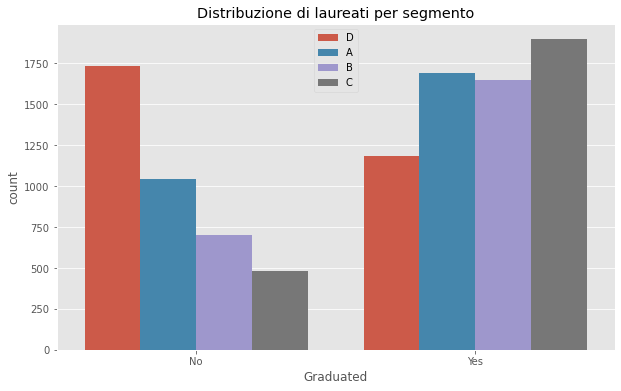

In [18]:
sns.countplot(data=data, x='Graduated', hue='Segmentation')
plt.legend(loc='upper center')
plt.title('Distribuzione di laureati per segmento');

Osservando gli ultimi due grafici, possiamo notare che il segmento D è quello che contiene la maggioranza di clienti non laureati e non sposati. In precedenza avevamo ipotizzato che il segmento D potesse far riferimento alle automobili sportive. Tuttavia notiamo che la maggiorparte dei cienti nel segmento D non è laureata, e di solito ciò corrisponde ad un livello di reddito più basso che non dovrebbe essere compatibile con il segmento delle auto sportive, ma potrebbe corrispondere al segmento delle auto più economiche oppure usate. Visualizziamo quali sono le principali attività lavorative dei nostri clienti.

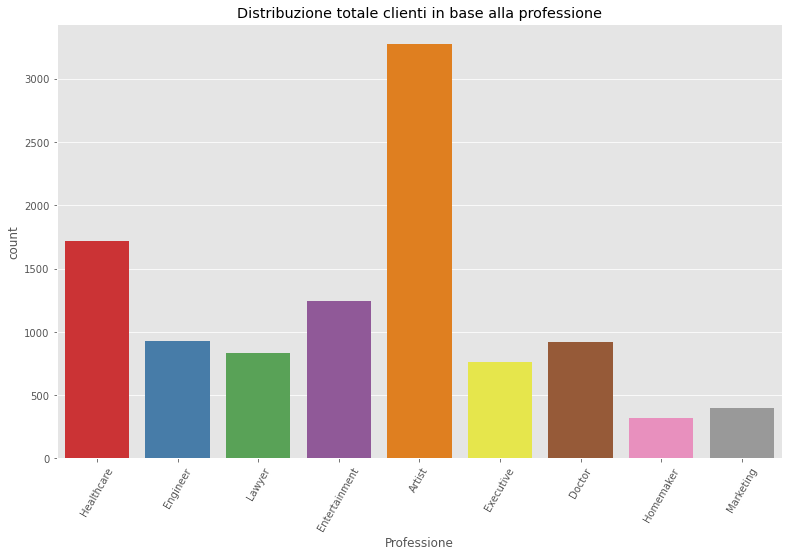

In [19]:
plt.figure(figsize=(13,8))
sns.countplot(x=data.Profession, palette = 'Set1')
plt.title('Distribuzione totale clienti in base alla professione')
plt.xlabel('Professione')
plt.xticks(rotation=60);

La maggior parte dei clienti sono artisti, mentre la seconda professione più rappresentata è l'assistenza sanitaria. Adesso normalizziamo il numero di clienti e vediamo come si distribuiscono, in percentuale, all'interno dei vari segmenti.

In [20]:
prof=data.groupby('Segmentation')['Profession'].value_counts(normalize=True).round(decimals=2).unstack()*100


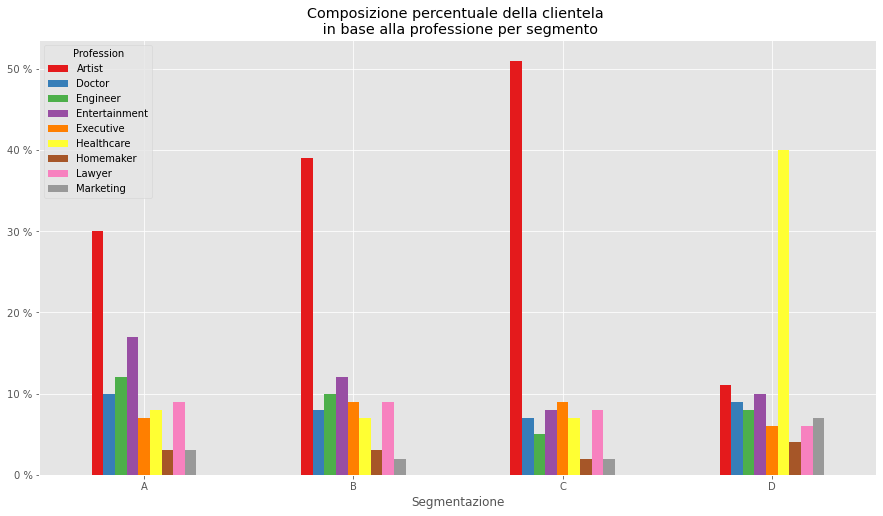

In [21]:
fig,ax = plt.subplots(1,1, figsize=(15,8))
col=sns.color_palette('Set1')
prof.plot(kind='bar',ax=ax, color=col)
ax.yaxis.set_major_formatter(EngFormatter(unit=u"%"))
ax.tick_params(axis='x', labelrotation=0)
ax.set_xlabel('Segmentazione')
ax.set_title('Composizione percentuale della clientela \n in base alla professione per segmento');

Il grafico mostra la composizione in percentuale della clientela per ogni segmento, suddivisa in base alla professione. Nei primi 3 segmenti la maggioranza dei clienti è composta da artisti, che sono anche la professione più rappresentata in termini assoluti. In particolare, per quanto riguarda il segmento C, gli artisti rappresentano più del 50% della clientela; probabilmente i veicoli di questo segmento hanno qualcosa utile alla professione degli artisti o una caratteristica estetica che attira di più le persone che lavorano nel mondo dell'arte. Per quanto riguarda il segmento D invece abbiamo un comportamento diverso . Circa il 40% dei clienti di questo segmento svolgono professioni relative all'assistenza sanitaria. Dai grafici precedenti abbiamo visto anche che il segmento D è quello più scelto dai clienti non sposati e non laureati. Per quanto riguarda il titolo di studio ha senso, perché non è necessaria una laurea per essere impiegati nell'assistenza sanitaria. Per quanto riguarda il reddito invece non possiamo trarre ulteriori conclusioni perché, come possiamo vedere dal grafico, anche professioni ad alto reddito (come dirigenti e avvocati) sono abbastanza rappresentate anche nel segmento D. 

Vediamo come è distribuito il punteggio di spesa del cliente rispetto ai segmenti

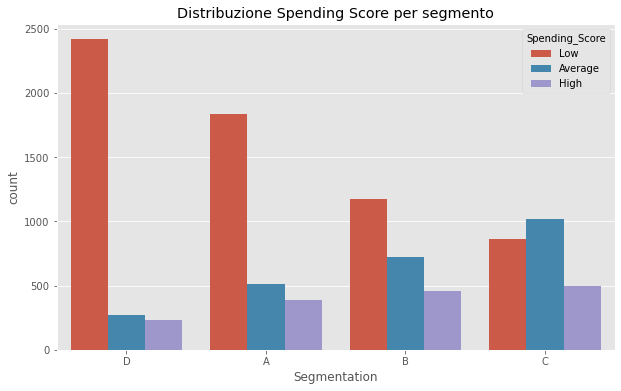

In [22]:
sns.countplot(data=data, x='Segmentation', hue='Spending_Score')
plt.title('Distribuzione Spending Score per segmento');

Nel segmento D ritroviamo la maggior parte dei clienti con un punteggio di spesa basso. Questa categoria costituisce comuneque la classe dominante in tutti i segmeti tranne in quello C, dove la più rappresentativa è quella con punteggio di spesa medio, ed è anche la classe con più clienti con punteggio di spesa alto. Ricordiamo che lo spending score è un punteggio assegnato in base alle spese effettuate dai clienti e dal loro comportamento in generale. Senza sapere come questo score viene calcolato non possiamo trarre ulteriori conclusioni dal grafico.

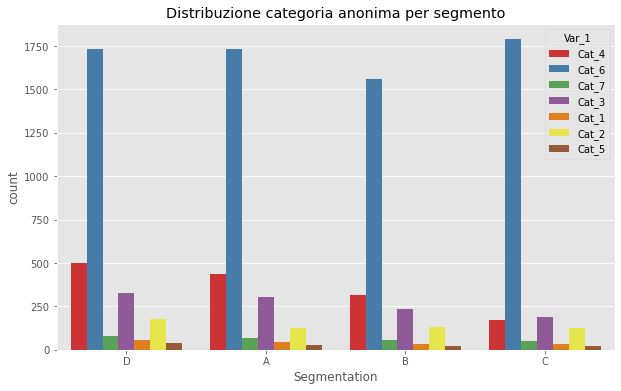

In [23]:
sns.countplot(data=data, x='Segmentation', hue='Var_1', 
              palette = 'Set1')
plt.title('Distribuzione categoria anonima per segmento');

La categoria 6 è la più rappresentativa in ogni segmento 

### variabili numeriche

Le variabili numeriche sono Age, Work_Experience e Family_Size. Come prima cosa definiamo una funzione per identificare i valori outliers nelle variabili numeriche e rimuoverli.

In [24]:
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n )
    return multiple_outliers
outliers_to_drop = detect_outliers(data, 2, ['Age', 'Work_Experience', 'Family_Size'])
print('dobbiamo eliminare {} indici:'.format(len(outliers_to_drop)), outliers_to_drop)

dobbiamo eliminare 0 indici: []


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10390 entries, 0 to 2626
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           10390 non-null  object 
 1   Ever_Married     10390 non-null  object 
 2   Age              10390 non-null  int64  
 3   Graduated        10390 non-null  object 
 4   Profession       10390 non-null  object 
 5   Work_Experience  10390 non-null  float64
 6   Spending_Score   10390 non-null  object 
 7   Family_Size      10390 non-null  float64
 8   Var_1            10390 non-null  object 
 9   Segmentation     10390 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 1.1+ MB


In Questo dataset non abbiamo valori outliers da eliminare. Visualizziamo la correlazione delle variabili numeriche con la correlation matrix

Text(0.5, 1.0, 'Correlazione fra le variabili numeriche')

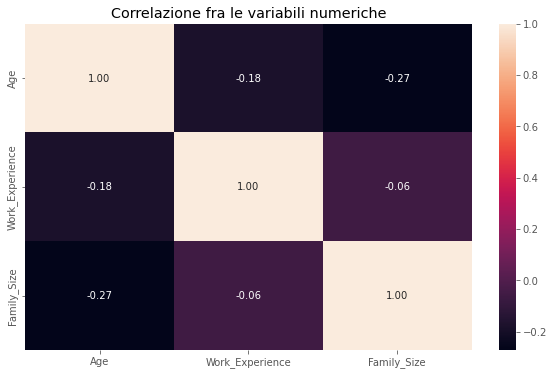

In [26]:
sns.heatmap(data[['Segmentation','Age','Work_Experience','Family_Size']].corr(), annot=True, fmt='.2f')
plt.title('Correlazione fra le variabili numeriche')

Possiamo vedere che le variabili Età e esperienza lavorativa sono negativamente correlate, che è una cosa normale.

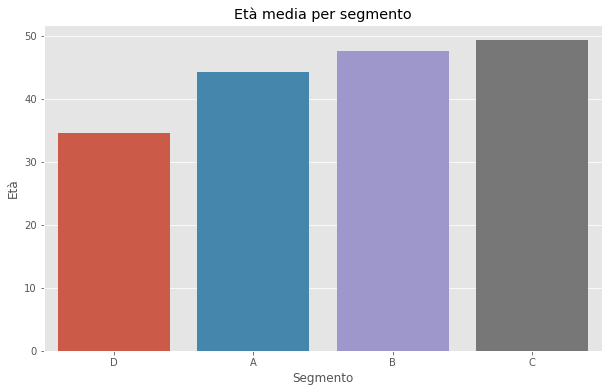

In [27]:
sns.barplot(y='Age', x='Segmentation', data=data, ci=None)
plt.title('Età media per segmento')
plt.xlabel('Segmento')
plt.ylabel('Età');

Il segmento D è quello con l'età media minore, mentre il segmento C registra l'età media più elevata.

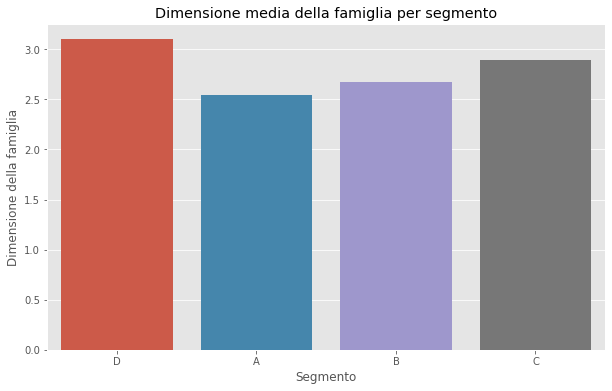

In [28]:
sns.barplot(y='Family_Size', x='Segmentation',data=data, ci=None)
plt.title('Dimensione media della famiglia per segmento')
plt.xlabel('Segmento')
plt.ylabel('Dimensione della famiglia');

Il segmento D in media ha i clienti con le famiglie più numerose.

In [29]:
Work_S =  data[['Segmentation','Work_Experience']].groupby('Segmentation', as_index=False).mean().sort_values(by= 'Segmentation', ascending=False)
print(Work_S)

  Segmentation  Work_Experience
3            D         2.694521
2            C         2.143277
1            B         2.263918
0            A         2.668615


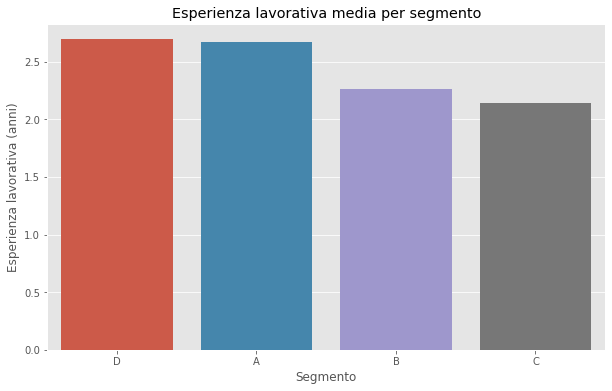

In [30]:
sns.barplot(y='Work_Experience', x='Segmentation', data=data, ci=None)
plt.title('Esperienza lavorativa media per segmento')
plt.xlabel('Segmento')
plt.ylabel('Esperienza lavorativa (anni)');

La classe D e la classe A sono molto simili in termini di esperienza lavorativa media, ma ricordiamo che la classe D è il segmento con l'età media più bassa.

# Preprocessing


## Encoding

Prima di addestrare un modello di machine learning, dobbiamo assicurarci che tutte le variabili categoriche siano espresse in termini numerici.

In [31]:
data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,A


In [32]:
data.dtypes

Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object

In [33]:
#selezione solo le colonne non numeriche
non_numeric = data.select_dtypes('object')
non_numeric.columns

Index(['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score',
       'Var_1', 'Segmentation'],
      dtype='object')

In [34]:
#Valori unici per ogni colonna non numerica
for column in non_numeric:
    print(f"{column}: {data[column].unique()}")

Gender: ['Male' 'Female']
Ever_Married: ['No' 'Yes']
Graduated: ['No' 'Yes']
Profession: ['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing']
Spending_Score: ['Low' 'Average' 'High']
Var_1: ['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' 'Cat_5']
Segmentation: ['D' 'A' 'B' 'C']


In [35]:
#Codifica one hot
data = pd.get_dummies(data, columns=['Profession','Spending_Score', 'Var_1'])
data

,Gender,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Segmentation,Profession_Artist,Profession_Doctor,Profession_Engineer,...,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,Male,No,22,No,1.0,4.0,D,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,Female,Yes,38,Yes,1.0,3.0,A,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,Female,Yes,67,Yes,1.0,1.0,B,0,0,1,...,0,0,1,0,0,0,0,0,1,0
3,Male,Yes,67,Yes,0.0,2.0,B,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,Female,Yes,40,Yes,1.0,6.0,A,0,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2622,Male,No,29,No,9.0,4.0,B,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2623,Female,No,35,Yes,1.0,1.0,A,0,1,0,...,0,0,1,0,0,0,0,0,1,0
2624,Female,No,53,Yes,1.0,2.0,C,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2625,Male,Yes,47,Yes,1.0,5.0,C,0,0,0,...,0,1,0,0,0,0,1,0,0,0


A questo punto ci restano soltanto le variabili binarie e la variabile target (che non posso convertire con la codifica one hot) che possiamo convertire utilizzando LabelEncoder. Come prima cosa riselezioniamo le colonne non numeriche che sono rimaste dopo la prima trasformazione.

In [36]:
non_numeric = data.select_dtypes('object')
non_numeric.columns

Index(['Gender', 'Ever_Married', 'Graduated', 'Segmentation'], dtype='object')

In [37]:
encoder=LabelEncoder()

#Converto le colonne binarie
for column in non_numeric:
    data[column] = encoder.fit_transform(data[column])

In [38]:
data.dtypes

Gender                        int32
Ever_Married                  int32
Age                           int64
Graduated                     int32
Work_Experience             float64
Family_Size                 float64
Segmentation                  int32
Profession_Artist             uint8
Profession_Doctor             uint8
Profession_Engineer           uint8
Profession_Entertainment      uint8
Profession_Executive          uint8
Profession_Healthcare         uint8
Profession_Homemaker          uint8
Profession_Lawyer             uint8
Profession_Marketing          uint8
Spending_Score_Average        uint8
Spending_Score_High           uint8
Spending_Score_Low            uint8
Var_1_Cat_1                   uint8
Var_1_Cat_2                   uint8
Var_1_Cat_3                   uint8
Var_1_Cat_4                   uint8
Var_1_Cat_5                   uint8
Var_1_Cat_6                   uint8
Var_1_Cat_7                   uint8
dtype: object

Adesso le variabili sono tutte numeriche e possono essere usate in un modello di machine learning

## Split

La nostra variabile target è il segmento di appartenenza dei clienti. 

In [39]:
y = data['Segmentation'].copy()

In [40]:
X = data.drop('Segmentation', axis=1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [42]:
print('X_train shape : {}'.format(X_train.shape))
print('y_train shape : {}'.format(y_train.shape))
print('X_test shape : {}'.format(X_test.shape))
print('y_test shape : {}'.format(y_test.shape))

X_train shape : (7272, 25)
y_train shape : (7272,)
X_test shape : (3118, 25)
y_test shape : (3118,)


## Scaling

Utilizzo **Standard Scaler** per scalare i dati 

In [43]:
scaler = StandardScaler()
#fit_transform per il train test
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
#transform per il test set
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [44]:
X_train

,Gender,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,...,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,0.917322,0.864186,-0.750059,0.784399,1.380336,-0.524825,-0.681438,-0.312241,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
1,-1.090130,-1.157158,-1.350768,-1.274861,-0.758618,-0.524825,-0.681438,-0.312241,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,2.502945,-0.10345,-1.387085,-0.149991
2,0.917322,0.864186,0.090932,-1.274861,-0.453053,0.139265,1.467485,-0.312241,-0.312241,-0.364778,...,1.773683,-0.416499,-1.253204,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
3,0.917322,-1.157158,-0.689989,-1.274861,-0.758618,-1.188915,-0.681438,-0.312241,-0.312241,2.741391,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
4,-1.090130,-1.157158,-0.209422,0.784399,1.074771,-0.524825,-0.681438,-0.312241,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7267,0.917322,0.864186,0.391287,-1.274861,-0.453053,0.139265,-0.681438,-0.312241,-0.312241,2.741391,...,1.773683,-0.416499,-1.253204,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
7268,-1.090130,-1.157158,-0.750059,0.784399,1.991466,-1.188915,-0.681438,-0.312241,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
7269,0.917322,-1.157158,-0.930272,-1.274861,-0.453053,-0.524825,-0.681438,-0.312241,-0.312241,2.741391,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
7270,0.917322,0.864186,-0.149351,-1.274861,1.074771,0.139265,-0.681438,-0.312241,-0.312241,-0.364778,...,-0.563799,2.400969,-1.253204,-0.131169,-0.241262,-0.333028,2.502945,-0.10345,-1.387085,-0.149991


In [45]:
X_test

,Gender,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,...,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,-1.090130,-1.157158,-0.029209,0.784399,-0.453053,-0.524825,1.467485,-0.312241,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
1,-1.090130,-1.157158,-0.509776,0.784399,1.991466,-1.188915,-0.681438,-0.312241,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
2,-1.090130,0.864186,1.292349,0.784399,-0.758618,-0.524825,1.467485,-0.312241,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
3,0.917322,-1.157158,-0.870201,-1.274861,-0.453053,0.803356,-0.681438,3.202650,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
4,0.917322,-1.157158,-1.470909,-1.274861,3.213725,0.139265,-0.681438,-0.312241,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,-1.387085,6.667083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,0.917322,-1.157158,-1.110484,0.784399,1.685901,-1.188915,-0.681438,3.202650,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
3114,0.917322,0.864186,-0.629918,-1.274861,-0.758618,-0.524825,-0.681438,-0.312241,3.202650,-0.364778,...,1.773683,-0.416499,-1.253204,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
3115,0.917322,-1.157158,-1.290697,-1.274861,-0.453053,0.139265,-0.681438,-0.312241,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
3116,0.917322,0.864186,0.811782,0.784399,-0.453053,1.467446,-0.681438,-0.312241,-0.312241,-0.364778,...,1.773683,-0.416499,-1.253204,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991


A questo punto possiamo addestrare i nostri modelli di machine learning.

# Machine Learning

## Addestramento Modelli

### Logistic Regression

In [46]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

46.69

### Support Vector Machines

In [47]:
svc = SVC()
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train)*100, 2)
acc_svc

51.24

### K-nearest neighbours (KNN)

In [48]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

58.68

### Gaussian naive bayes

In [49]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian

43.78

### Perceptron

In [50]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)
acc_perceptron

32.04

### Linear SVC

In [51]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
acc_linear_svc

46.2

### Stochastic gradient descent

In [52]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
acc_sgd

42.26

### Decision Tree

In [53]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

93.45

### Random Forest


In [54]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

93.45

In [56]:
models = pd.DataFrame({'Model':['Support Vector Machines', 'KNN', 'Logistic Regression', 
                                 'Random Forest', 'Naive Bayes', 'Perceptron', 'Stochastic Gradient Decent', 
                                 'Linear SVC', 'Decision Tree'], 'Score':[acc_svc, acc_knn, acc_log, acc_random_forest, acc_gaussian, acc_perceptron,
                                 acc_sgd, acc_linear_svc, acc_decision_tree]})

models.sort_values(by='Score', ascending = False, ignore_index = True)

,Model,Score
0,Random Forest,93.45
1,Decision Tree,93.45
2,KNN,58.68
3,Support Vector Machines,51.24
4,Logistic Regression,46.69
5,Linear SVC,46.20
6,Naive Bayes,43.78
7,Stochastic Gradient Decent,42.26
8,Perceptron,32.04


Decision Tree e Random Forest potrebbero essere affetti da overfitting perché hanno un'accuratezza molto elevata sul training set, per questo motivo bisogna utilizzare altre tecniche per indagare l'accuratezza dei nostri modelli.

## K-fold Cross Validation

Misuriamo l'accuratezza dei classificatori utilizzando K-fold Cross Validation sul training set

In [58]:
# Creiamo un lista che contiene i classificatori

classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(SVC())
classifiers.append(KNeighborsClassifier(n_neighbors = 5))
classifiers.append(GaussianNB())
classifiers.append(Perceptron())
classifiers.append(LinearSVC())
classifiers.append(SGDClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())


len(classifiers)

9

In [59]:
# Creiamo una lista che contiene i risultati di validazione per ogni classificatore
#Utilizziamo 10 fold dei dati
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring = 'accuracy', cv = 10))

In [60]:
#Calcoliamo media e deviazione standard ottenuti dalla cross validation per ogni classificatore

cv_mean = []
cv_std = []
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [61]:
#Creiamo una tabella con i risultati 
cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean, 
                       'Cross Validation Std': cv_std, 
                       'Algorithm': ['Logistic Regression',
                                     'Support Vector Machines',
                                     'KNN', 'Gausian Naive Bayes',
                                     'Perceptron',
                                     'Linear SVC',
                                     'Stochastic Gradient Descent',
                                     'Decision Tree',
                                     'Random Forest']})
cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)

,Cross Validation Mean,Cross Validation Std,Algorithm
0,0.459017,0.014272,Logistic Regression
1,0.455993,0.015261,Support Vector Machines
2,0.454481,0.010254,Linear SVC
3,0.428355,0.007814,Gausian Naive Bayes
4,0.411852,0.018147,Random Forest
5,0.410614,0.012939,KNN
6,0.408272,0.024377,Stochastic Gradient Descent
7,0.364962,0.015635,Decision Tree
8,0.346535,0.027545,Perceptron


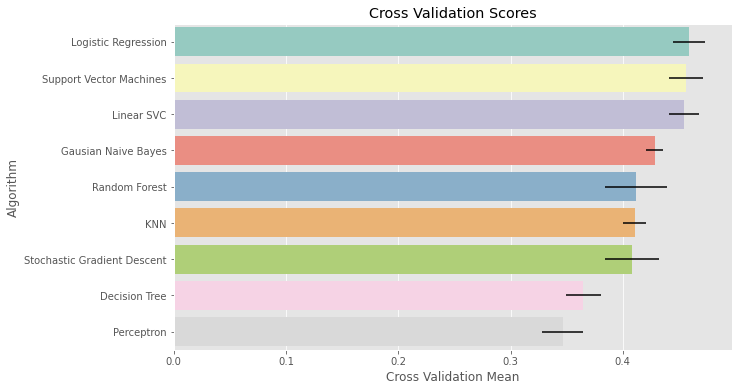

In [62]:
sns.barplot('Cross Validation Mean', 'Algorithm', data = cv_res, order = cv_res.sort_values(by = 'Cross Validation Mean', ascending = False)['Algorithm'], palette = 'Set3', **{'xerr': cv_std})
plt.ylabel('Algorithm')
plt.title('Cross Validation Scores');

Come sospettavamo, Decision Tree e Random Forest soffrivano di Overftting sul training set, il modello più performante dopo la cross validation è Logistic Regression con un'accuratezza del 46%. È possibile migliorare questo punteggio aggiustando i parametri di questo classificatore con grid search.

## Validazione degli Iperparametri per Logistic Regression

In [63]:
param_grid = {"C":np.logspace(-3,3,7), 
              "penalty":["l1","l2"]}
grid_log = GridSearchCV(LogisticRegression(), param_grid, cv=10)
grid_log.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

In [64]:
print("Best parameters: ", grid_log.best_params_) 

Best parameters:  {'C': 0.01, 'penalty': 'l2'}


In [65]:
#addestriamo il modello con questi parametri
predictions = grid_log.predict(X_test)
acc_logistic = round(grid_log.score(X_train, y_train) * 100, 2)

In [66]:
acc_logistic

46.74

L'accuratezza di Logistic Regressor con iperparametri validati è circa del **47%**. Possiamo visualizzare anche altre metriche di valutazione per capire meglio come funziona il nostro modello:

In [67]:
print(classification_report(y_test, Y_pred, target_names=['A','B','C','D']))

              precision    recall  f1-score   support

           A       0.40      0.41      0.40       821
           B       0.28      0.26      0.27       686
           C       0.43      0.42      0.42       714
           D       0.55      0.58      0.56       897

    accuracy                           0.43      3118
   macro avg       0.41      0.42      0.42      3118
weighted avg       0.42      0.43      0.42      3118



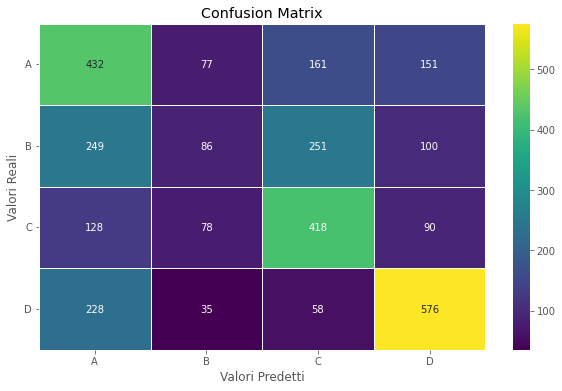

In [68]:
cm = confusion_matrix(y_test, predictions, labels=grid_log.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_log.classes_)

sns.heatmap(cm, annot=True, fmt='d',linewidths=.5, cmap='viridis', 
            xticklabels=['A','B','C','D'], yticklabels=['A','B','C','D'])

plt.xlabel('Valori Predetti')
plt.ylabel('Valori Reali')
plt.title('Confusion Matrix')
plt.yticks(rotation=0);

Dal classification report è possibile notare che la classe B ha sia una precision che una recall più basse rispetto alle altre classi, ciò è confermato anche dalla confusion matrix. È possibile notare come la classe B sia quella con più errori di classificazione, in particolare la classe B viene spesso classificata come A o come C. Questo problema può essere risolto aggiungendo più istanze appertenti alla classe B, in modo che l'algoritmo possa avere a disposizione maggiori elementi per distinguerle dalle altre.